## Importing the libraries

In [1]:
import os
import random
import re

os.chdir("/home/charon/project/nmos_inference/")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from plot_utils import get_cmap_slice

from pipeline.src.utils.data_util import down_sample,
from causallearn.search.Granger.Granger import Granger
from statsmodels.stats.diagnostic import unitroot_adf


SyntaxError: trailing comma not allowed without surrounding parentheses (3722752103.py, line 13)

## Multiprocessing

In [3]:
def numpy_split_df(df, split_num):
    lst_index = list(map(lambda a: a.tolist(), np.array_split([i for i in range(len(df))], split_num)))
    chunk_list = []
    for idx in lst_index:
        df_split = df.iloc[idx[0]: idx[-1] + 1]
        chunk_list.append(df_split)
    return chunk_list


def apply_parallel(df, func, num_cpu, G):
    # divide events into chunks
    chunk_list = numpy_split_df(df, num_cpu*10)
    examples_list = Parallel(n_jobs=num_cpu, backend='multiprocessing')(delayed(func)(split_df, G)
                                                                        for split_df in tqdm(chunk_list, desc="Parallel", total=len(chunk_list)))
    return examples_list

## Load Data

In [4]:
games = {"DonkeyKong": {}, "Pitfall": {}, "SpaceInvaders": {}}
for game in games.keys():
    games[game]["valid_df"] = pd.read_csv(f"./envs/{game}/valid_balanced_42.csv")
    games[game]["seqs"] = np.load(f"./envs/{game}/original_3510_512.npy", mmap_mode='r')
    games[game]["effect"] = np.load(f"./envs/{game}/causal_effect_512.npy", mmap_mode='r')


ts_info = pd.read_csv('./raw_data/transistors.csv')
ws_info = pd.read_csv('./raw_data/wires.csv')

## Causal Effect Plot

### Load Diffs Data

In [5]:
# TODO: 3510 transistor grid plot for causal effect strength (time length: 400)
for idx, (name, game) in enumerate(games.items()):
    game["strength"] = [np.sum(np.abs(game["effect"][i])) - np.sum(np.abs(game["effect"][i][i])) for i in tqdm(range(game["effect"].shape[0]))]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3510/3510 [00:08<00:00, 403.96it/s]


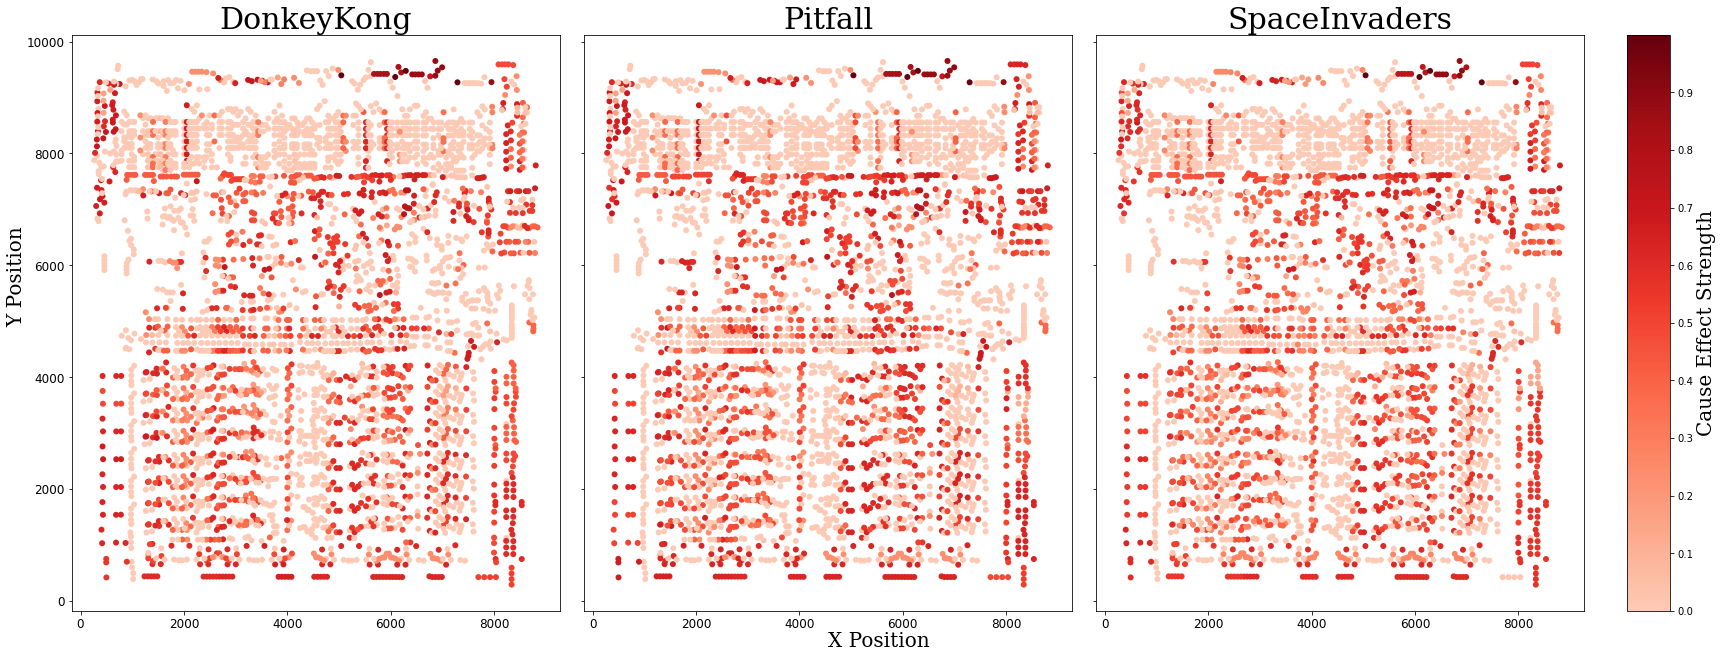

In [6]:
max_effect = np.max(np.max([game["strength"] for game in games.values()]))
fig, axs = plt.subplots(1, len(games), figsize=(len(games)*10, 10), sharex=True, sharey=True)
for idx, (name, game) in enumerate(games.items()):
    # Calculate the causal effect of every transistor (sum diff value through 400 time steps)
    causal_effect = game["strength"]
    # Normalize the causal effect
    causal_effect = np.array(causal_effect) / max_effect
    # Heatmap of causal effect
    cmap = get_cmap_slice(plt.get_cmap("Reds"), 0.2, 1.0)
    im = axs[idx].scatter(ts_info.x, ts_info.y, c=causal_effect, cmap=cmap, edgecolor='none')
    axs[idx].tick_params(axis='x', labelsize=12)
    axs[idx].tick_params(axis='y', labelsize=12)
    axs[idx].set_title(name, fontdict={'family': 'Serif'}, fontsize=30)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.05)
fig.text(0.45, 0.05, "X Position", fontdict={'family': 'Serif'}, size=20)
fig.text(0.07, 0.5, "Y Position", rotation='vertical', fontdict={'family': 'Serif'}, size=20)
cbar = fig.colorbar(im, cax=plt.axes([0.82, 0.1, 0.02, 0.8]))
cbar.set_label('Cause Effect Strength', fontdict={'family': 'Serif'}, size=20)
cbar.set_ticks(ticks=np.arange(0.0, 1.0, 0.1), fontsize=10)
fig.clim = (0.0, 1.0)


In [10]:
print(ts_info.head(20))
print(ws_info.head(20))

                          bb    c1    c2  gate name     on       x       y  \
0   [1450, 1510, 5143, 5320]   558   217   357   t0  False  1480.0  5231.5   
1     [5424, 5629, 548, 922]   657   349  1608   t1  False  5526.5   735.0   
2   [3867, 3899, 2465, 2642]   558  1146   412   t2  False  3883.0  2553.5   
3   [7907, 7990, 9237, 9311]   558   943   558   t3  False  7948.5  9274.0   
4     [1893, 1910, 530, 927]   230   657   826   t4  False  1901.5   728.5   
5   [8489, 8527, 6063, 6388]   558  1319    82   t5  False  8508.0  6225.5   
6     [6029, 6049, 762, 791]   289  1514   821   t6  False  6039.0   776.5   
7   [7282, 7300, 9212, 9329]   558  1171   558   t7  False  7291.0  9270.5   
8   [7302, 7622, 3402, 3430]   558  1199   945   t8  False  7462.0  3416.0   
9   [1629, 1647, 1796, 1826]   524  1548   710   t9  False  1638.0  1811.0   
10  [1435, 1458, 4798, 4969]   558   220   190  t10  False  1446.5  4883.5   
11   [897, 1058, 4652, 4668]  1247   657    38  t11  False   977

In [141]:
ts_info[ts_info["gate"]==217]

,bb,c1,c2,gate,name,on,x,y,pos
2673,"[1253, 1269, 5108, 5214]",696,558,217,t2673,False,1261.0,5161.0,2673
2819,"[1646, 1664, 4245, 4282]",558,413,217,t2819,False,1655.0,4263.5,2819


In [140]:
ws_info[ws_info.wireid==217]

,wireid,c1c2s,gates,pullup,name
214,217,1,2,True,0/ADL0


## Granger Causal Test (Pairwise)

### Functions

In [9]:
def granger_predict(ts, G):
    try:
        adj_mat = G.granger_test_2d(ts)[1]
        adj_by_time_lag = [adj_mat[:, i:i+2] for i in range(len(adj_mat[0]), 2)]
        # for p in adj_by_time_lag:
        #     if np.sum(p) > 2:
        p = adj_by_time_lag[-1]

        if p[1, 0] == 1:
        # t1 causing t2 --> t1 cause t2 == label(1)
            return 1
    except:
        pass
    return 0


In [10]:
def granger_test(df, G):
    total = len(df)
    correct = 0
    for idx, row in tqdm(df.iterrows(), total=total):
        t1 = seqs[row["transistor_1"]].reshape(-1,1)
        t2 = seqs[row["transistor_2"]].reshape(-1,1)
        ts = np.concatenate((t1, t2), axis=1)
        label = row["label"]
        pred = granger_predict(ts, G)
        if pred == label:
            correct += 1
    # pred = np.array([granger_predict(np.concatenate((seqs[row["transistor_1"]].reshape(-1,1),
    #                                         seqs[row["transistor_2"]].reshape(-1,1)), axis=1), G)
    #                                         for idx, row in tqdm(df.iterrows(), total=total)])
    # print(pred)
    # correct = sum(pred==df.label)
    return correct/total

def granger_test_parallel(df, G):
    num_cpu = cpu_count()
    total = len(df)
    correct = apply_parallel(df, granger_test, num_cpu, G)
    correct = sum(correct)
    return correct/total

### Test

In [11]:
# test demo
G = Granger(maxlag=5, significance_level=0.05/223962)
example = df.iloc[998]
t1 = seqs[example["transistor_1"]].reshape(-1,1)
t2 = seqs[example["transistor_2"]].reshape(-1,1)
ts = np.concatenate((t1, t2), axis=1)

# [(time_lag=1: (1,1), (1,2), (2,1), (2,2)),(time_lag=2: (1,1), (1,2), (2,1), (2,2))]
# smaller p-value means more causal
p_value_matrix = G.granger_test_2d(ts)
# coeff = G.granger_lasso(data)
print(f"P-value matrix: \n", p_value_matrix[0])
print(f"Adjency matrix: \n", p_value_matrix[1])
print(f"Ground truth is t1 cause t2") if example["label"] == 1 else \
print(f"Ground truth is t1 does not cause t2")

P-value matrix: 
 [[0.000e+00 1.681e-01 0.000e+00 3.790e-02 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 3.000e-04]
 [1.843e-01 0.000e+00 4.060e-02 0.000e+00 3.700e-03 0.000e+00 1.000e-04
  0.000e+00 1.100e-03 0.000e+00]]
Adjency matrix: 
 [[1 0 1 0 1 1 1 1 1 0]
 [0 1 0 1 0 1 0 1 0 1]]
Ground truth is t1 does not cause t2


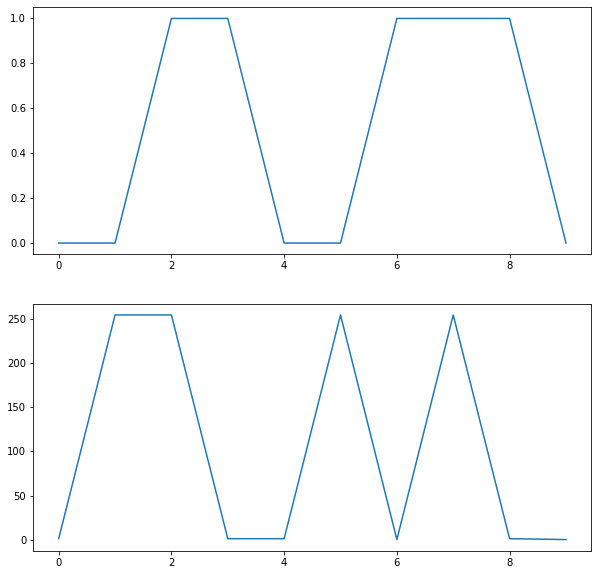

In [13]:
# Stability test
temp = seqs[df.iloc[0]["transistor_1"]]
diff_temp = np.diff(temp, n=2)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(temp[:10])
plt.subplot(212)
plt.plot(diff_temp[:10])

In [12]:
# granger test
# use stabilized data
seqs = np.load("./project/nmos_inference/data_v1/2nd_diff_3510_400.npy", mmap_mode='r')

nums = len(df)
G = Granger(maxlag=2, significance_level=0.05/nums) # Bonferroni correction
print(granger_test(df.iloc[:50000], G))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [10:20<00:00, 80.58it/s]

0.50072


In [ ]:
# def strong_interpret_p_mat(p_value_matrix):
#     p_by_time_lag = [p_value_matrix[:, i:i+2] for i in range(0, len(p_value_matrix), 2)]
#     for p in p_by_time_lag:
#         if p[0, 1] == 0 and p[1, 0] == 1:
#         # t2 not causing t1 & t1 causing t2 --> t1 cause t2 == label(1)
#
#         elif p[0, 1] == 1 and p[1, 0] == 0:
#         # t2 causing t1 & t1 not causing t2 --> t2 cause t1 == label(0)
#
#         elif p[0, 1] == 0 and p[1, 0] == 0:
#         # t2 not causing t1 & t1 not causing t2 --> t2 has no relationship with t1 == label(0)
#
#         elif p[0, 1] == 1 and p[1, 0] == 1:
#         # t2 causing t1 & t1 causing t2 --> t2 has no relationship with t1 == label(0)
#
#         else:
#             print("Something is wrong")
#
#         else:
#             print("Error")
#
#     print()

## Augmentation Plot

In [3]:
import os
os.chdir("/home/charon/project/nmos_inference/")
import matplotlib.pyplot as plt
from pipeline.src.utils.data_util import white_noisen, down_sample, gaussian_noisen
import numpy as np
from plot_utils import digits2color
import random
seqs = np.load(f"./envs/DonkeyKong/original_3510_512.npy", mmap_mode='r')

Text(0.08, 0.5, 'Voltage')

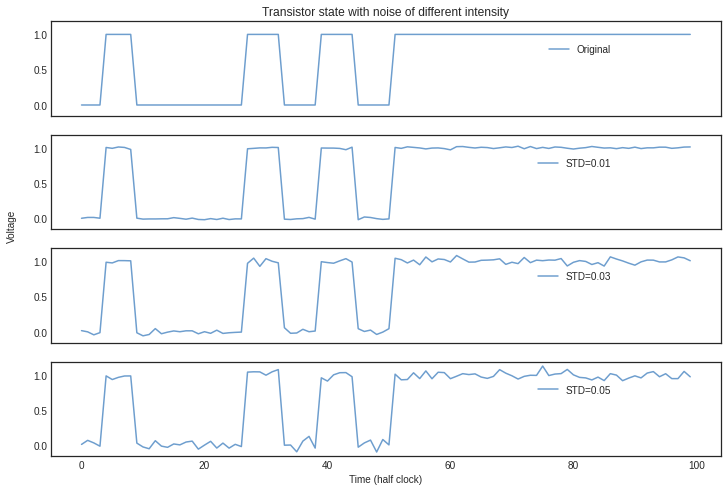

In [4]:
# TODO: add augmentation plot (noise, sample_rate, composition, transfer?)
import brewer2mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('seaborn-white')
chosen_idx = 1389
target_seq = seqs[chosen_idx]
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12, 8))
c = '#6e9ece'
# add gaussian noise
for i, noise in enumerate([0.0, 0.01, 0.03, 0.05]):
    noise_seq = target_seq + np.random.normal(0, noise, target_seq.shape)
    if i != 0:
        axs[i].plot(noise_seq[:100], c=c, label=f"STD={noise}")
    else:
        axs[i].plot(noise_seq[:100], c=c, label=f"Original")
    if i == 0:
        axs[i].set_title("Transistor state with noise of different intensity")
    if axs[i].get_subplotspec().is_last_row():
        axs[i].set_xlabel("Time (half clock)")
    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 0.85), fancybox=True, framealpha=0.5)
fig.text(0.08, 0.5, 'Voltage', ha='center', rotation='vertical')

Text(0.08, 0.5, 'Voltage')

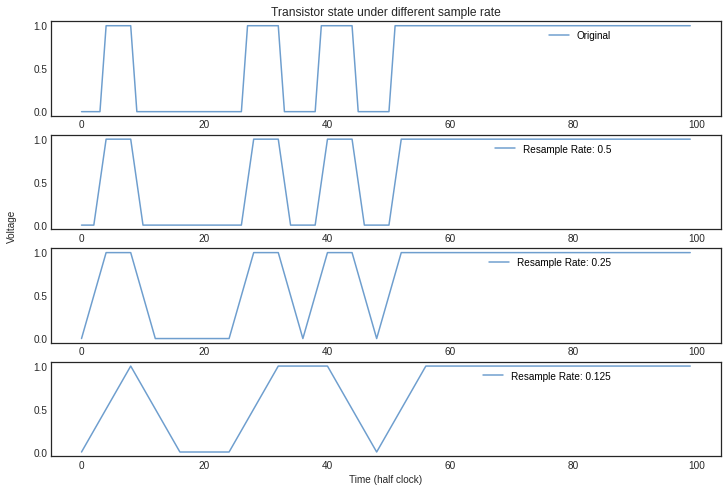

In [5]:
import scipy.signal as signal
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 8))
c = '#6e9ece'
# downsample noise
for i, sample_rate in enumerate([0.0, 0.5, 0.25, 0.125]):
    target_seq = seqs[chosen_idx]
    length = len(target_seq)
    if i != 0:
        target_seq = target_seq[::int(1/sample_rate)]
        target_seq = np.interp(np.arange(length), np.arange(length)[::int(1/sample_rate)], target_seq)
        # interpolate the sequence to the original length
        # target_seq = np.interp(target_seq)
        # target_seq = signal.resample(target_seq, original_length)

    if i != 0:
        axs[i].plot(target_seq[:100], c=c, label=f"Resample Rate: {sample_rate}")
    else:
        axs[i].set_title("Transistor state under different sample rate")
        axs[i].plot(target_seq[:100], c=c, label="Original")

    if axs[i].get_subplotspec().is_last_row():
        axs[i].set_xlabel("Time (half clock)")
    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 1.0), labelcolor='black')
fig.text(0.08, 0.5, 'Voltage', ha='center', rotation='vertical')

Text(0.08, 0.5, 'Voltage')

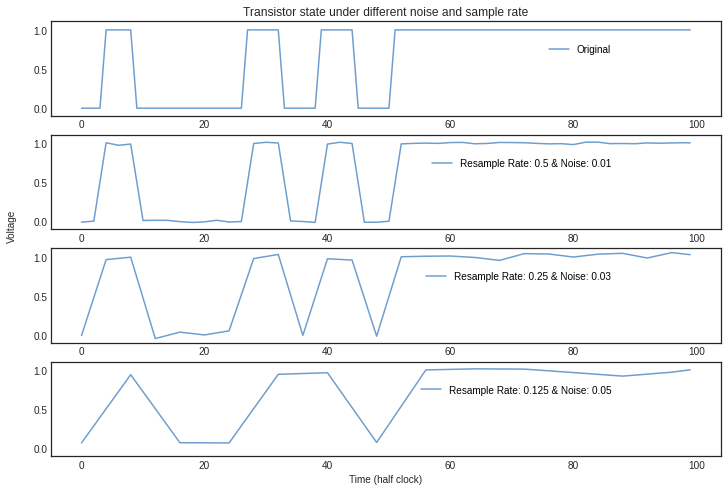

In [6]:
# import scipy.signal as signal
target_seq = seqs[chosen_idx]
length = len(target_seq)
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 8))
c = '#6e9ece'
# downsample noise
for i, (sample_rate, noise) in enumerate([(0.0, 0.0), (0.5, 0.01), (0.25, 0.03), (0.125, 0.05)]):
    target_seq = seqs[chosen_idx]
    length = len(target_seq)
    if i != 0:
        # composition augmentation
        target_seq = target_seq + np.random.normal(0.0, noise, target_seq.shape)
        target_seq = target_seq[::int(1/sample_rate)]
        target_seq = np.interp(np.arange(length), np.arange(length)[::int(1/sample_rate)], target_seq)

    if i != 0:
        axs[i].plot(target_seq[:100], c=c, label=f"Resample Rate: {sample_rate} & Noise: {noise}")
    else:
        axs[i].set_title("Transistor state under different noise and sample rate")
        axs[i].plot(target_seq[:100], c=c, label="Original")

    if axs[i].get_subplotspec().is_last_row():
        axs[i].set_xlabel("Time (half clock)")
    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 0.85), labelcolor='black')
fig.text(0.08, 0.5, 'Voltage', ha='center', rotation='vertical')

Text(0.08, 0.5, 'Voltage')

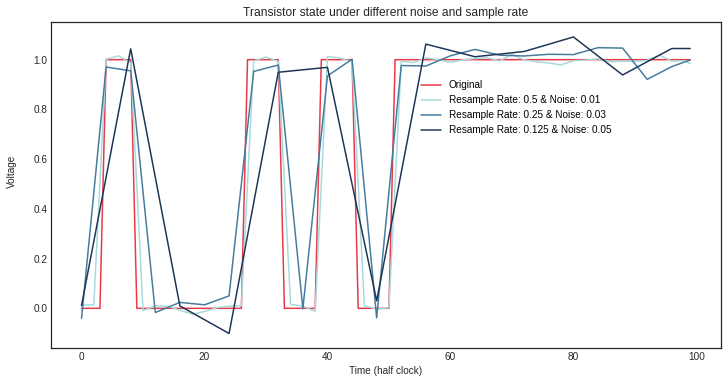

In [7]:
# import scipy.signal as signal
target_seq = seqs[chosen_idx]
length = len(target_seq)
fig = plt.figure(figsize=(12, 6))
cls = iter([(231/255, 56/255, 71/255), (168/255, 218/255, 219/255), (69/255, 123/255, 157/255), (29/255, 53/255, 87/255)])
# downsample noise
for i, (sample_rate, noise) in enumerate([(0.0, 0.0), (0.5, 0.01), (0.25, 0.03), (0.125, 0.05)]):
    target_seq = seqs[chosen_idx]
    length = len(target_seq)
    c = next(cls)
    if i != 0:
        # composition augmentation
        target_seq = target_seq + np.random.normal(0.0, noise, target_seq.shape)
        target_seq = target_seq[::int(1/sample_rate)]
        target_seq = np.interp(np.arange(length), np.arange(length)[::int(1/sample_rate)], target_seq)

    if i != 0:
        plt.plot(target_seq[:100], c=c, label=f"Resample Rate: {sample_rate} & Noise: {noise}")
    else:
        plt.plot(target_seq[:100], c=c, label="Original")

plt.title("Transistor state under different noise and sample rate")
plt.xlabel("Time (half clock)")
plt.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85), labelcolor='black')
fig.text(0.08, 0.5, 'Voltage', ha='center', rotation='vertical')

In [8]:

fig, axs = plt.subplots(len(chosen_seq), 1, figsize=(10, 6))
for i, ax in enumerate(axs):
    ax.plot(seqs[chosen_seq[i]][:100])


# tmp = seqs[1]
# tmp = tmp + np.random.normal(0, 0.01, tmp.shape)
# plt.plot(tmp)

NameError: name 'chosen_seq' is not defined

# Augmented Prediction Result

In [31]:
import pickle
with open("./tests/test_results_v2.pkl", "rb") as f:
    res = pickle.load(f)
res

{'Original': defaultdict(dict,
             {'DonkeyKong': {'corr_res': 0.4651607179417184,
               'decorr_res': 0.3966423258035897,
               'mutual_res': 0.5352487545212584,
               'granger_res': array([0.50774585, 0.54377943, 0.55463045, 0.54698697, 0.57448987])}}),
 'Noise=0.1': defaultdict(dict,
             {'DonkeyKong': {'corr_res': 0.47000614208694463,
               'decorr_res': 0.3959598716986283,
               'mutual_res': 0.49832798744284446,
               'granger_res': array([0.50167201, 0.50371937, 0.53988944, 0.53872927, 0.53852453])}}),
 'Noise=0.3': defaultdict(dict,
             {'DonkeyKong': {'corr_res': 0.4670033440251143,
               'decorr_res': 0.39630109875110897,
               'mutual_res': 0.49832798744284446,
               'granger_res': array([0.50167201, 0.5040606 , 0.53947997, 0.53845629, 0.53558998])}}),
 'Noise=0.5': defaultdict(dict,
             {'DonkeyKong': {'corr_res': 0.4681635160035488,
               'decorr_re

Text(0.08, 0.5, 'Accuracy')

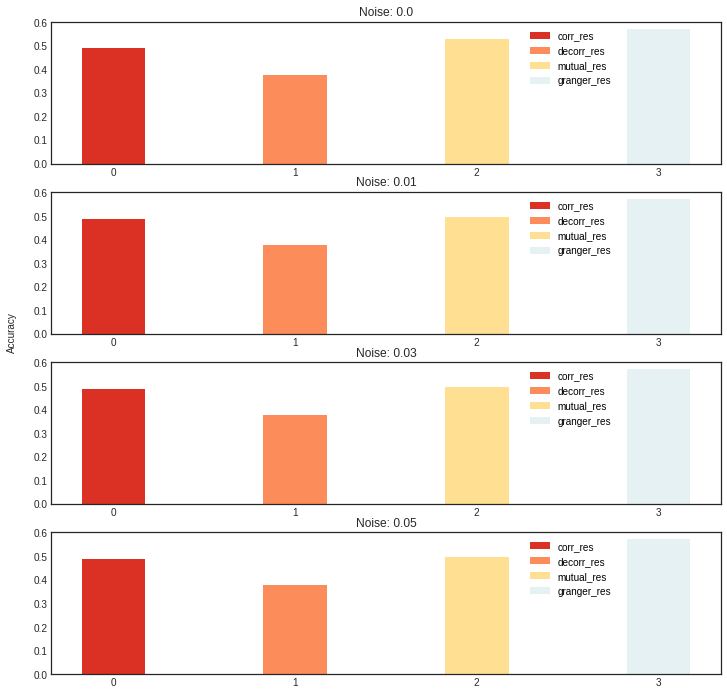

In [11]:
# group the results by methods
# one augmentation -> game: DonkeyKong -> methods: [corr, decorr, mutual, granger, lstm, tcn, trm]

# noise: 0.01, 0.03, 0.05
# import scipy.signal as signal
target_seq = seqs[chosen_idx]
length = len(target_seq)
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12))
c = '#6e9ece'
label = ["corr_res", "decorr_res", "mutual_res", "granger_res"]
cls = [219, 49, 36, 252, 140, 90, 255, 223, 146, 230, 241, 243, 144, 190, 224, 75, 116,178]
cls = digits2color(cls)
# downsample noise
for i, noise in enumerate([0.0, 0.01, 0.03, 0.05]):
    if i == 0:
        scores = res["Original"]["DonkeyKong"]
    else:
        scores = res[f"Noise={noise}"]["DonkeyKong"]

    for j, method in enumerate(label):
        v = scores[method]
        axs[i].bar(x=j, height=v, color=cls[j], width=0.35, label=method)
    axs[i].set_title(f"Noise: {noise}")
    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 0.85), labelcolor='black')
    axs[i].set_xticks(ticks=range(len(label)), label=label)


    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 1.0), labelcolor='black')
fig.text(0.08, 0.5, 'Accuracy', ha='center', rotation='vertical')

Text(0.08, 0.5, 'Accuracy')

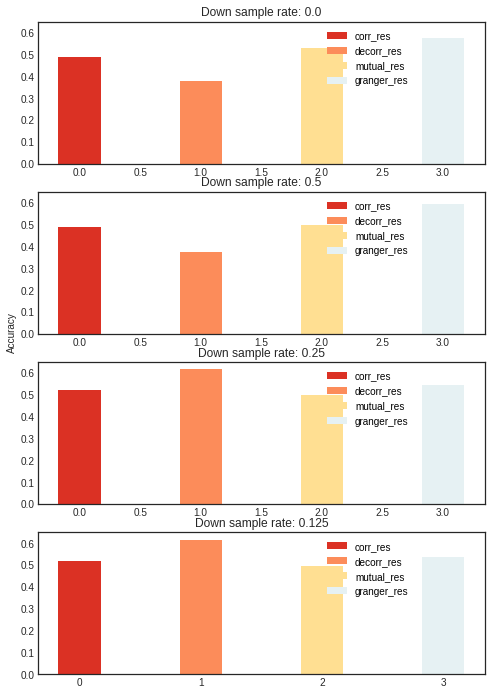

In [12]:
# group the results by methods
# one augmentation -> game: DonkeyKong -> methods: [corr, decorr, mutual, granger, lstm, tcn, trm]

# sample_rate: 0.5, 0.25, 0.125
# import scipy.signal as signal
target_seq = seqs[chosen_idx]
length = len(target_seq)
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(8, 12))
c = '#6e9ece'
label = ["corr_res", "decorr_res", "mutual_res", "granger_res"]
cls = [219, 49, 36, 252, 140, 90, 255, 223, 146, 230, 241, 243, 144, 190, 224, 75, 116,178]
cls = digits2color(cls)
# downsample noise
for i, noise in enumerate([0.0, 0.5, 0.25, 0.125]):
    if i == 0:
        scores = res["Original"]["DonkeyKong"]
    else:
        scores = res[f"Downsample={noise}"]["DonkeyKong"]

    for j, method in enumerate(label):
        v = scores[method]
        axs[i].bar(x=j, height=v, color=cls[j], width=0.35, label=method)
    axs[i].set_title(f"Down sample rate: {noise}")
    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 0.85), labelcolor='black')
    if axs[i].get_subplotspec().is_last_row():
        axs[i].set_xticks(ticks=range(len(label)), label=label)


    axs[i].legend(loc='upper right', bbox_to_anchor=(0.85, 1.0), labelcolor='black')
fig.text(0.08, 0.5, 'Accuracy', ha='center', rotation='vertical')

In [13]:
res["Original"]["DonkeyKong"]["lstm"] = 0.786
res["Original"]["DonkeyKong"]["tcn"] = 0.684
res["Original"]["DonkeyKong"]["trm"] = 0.616

res["Noise=0.01"]["DonkeyKong"]["lstm"] = 0.694
res["Noise=0.03"]["DonkeyKong"]["lstm"] = 0.727
res["Noise=0.05"]["DonkeyKong"]["lstm"] = 0.693
res["Noise=0.01"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.03"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.05"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.01"]["DonkeyKong"]["trm"] = 0.616
res["Noise=0.03"]["DonkeyKong"]["trm"] = 0.616
res["Noise=0.05"]["DonkeyKong"]["trm"] = 0.616

res["Downsample=0.5"]["DonkeyKong"]["lstm"] = 0.787
res["Downsample=0.25"]["DonkeyKong"]["lstm"] = 0.687
res["Downsample=0.125"]["DonkeyKong"]["lstm"] = 0.711
res["Downsample=0.5"]["DonkeyKong"]["tcn"] = 0.684
res["Downsample=0.25"]["DonkeyKong"]["tcn"] = 0.684
res["Downsample=0.125"]["DonkeyKong"]["tcn"] = 0.684
res["Downsample=0.5"]["DonkeyKong"]["trm"] = 0.616
res["Downsample=0.25"]["DonkeyKong"]["trm"] = 0.616
res["Downsample=0.125"]["DonkeyKong"]["trm"] = 0.616

res["Noise=0.01|Downsample=0.5"]["DonkeyKong"]["lstm"] = 0.736
res["Noise=0.03|Downsample=0.25"]["DonkeyKong"]["lstm"] = 0.695
res["Noise=0.05|Downsample=0.125"]["DonkeyKong"]["lstm"] = 0.697
res["Noise=0.01|Downsample=0.5"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.03|Downsample=0.25"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.05|Downsample=0.125"]["DonkeyKong"]["tcn"] = 0.684
res["Noise=0.01|Downsample=0.5"]["DonkeyKong"]["trm"] = 0.616
res["Noise=0.03|Downsample=0.25"]["DonkeyKong"]["trm"] = 0.616
res["Noise=0.05|Downsample=0.125"]["DonkeyKong"]["trm"] = 0.616


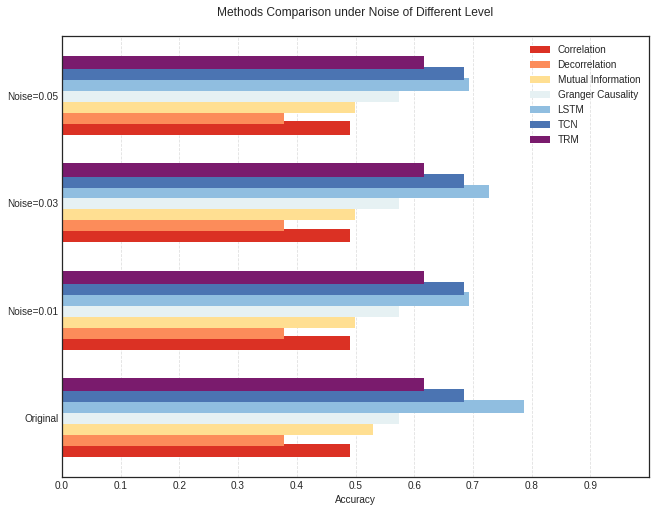

In [18]:
from collections import namedtuple
import numpy as np
import re
import matplotlib.pyplot as plt

methods = ["corr_res", "decorr_res", "mutual_res", "granger_res", "lstm", "tcn", "trm"]
label = ["Correlation", "Decorrelation", "Mutual Information", "Granger Causality", "LSTM", "TCN", "TRM"]
cls = [219, 49, 36, 252, 140, 90, 255, 223, 146, 230, 241, 243, 144, 190, 224, 75, 116,178, 122, 27, 109]
cls = digits2color(cls)
cls = cls*4

def plot_condition_results(res, conditions, cohort_size):
    game = "DonkeyKong"
    fig, ax1 = plt.subplots(figsize=(9, 7), constrained_layout=True)
    fig.canvas.manager.set_window_title('Eldorado K-8 Fitness Chart')

    if "|" in conditions[0]:
        key = "Combinations"
    else:
        key = re.search(r'.*?=', conditions[0]).group(0).strip('=')
    ax1.set_title(f'Methods Comparison under {key} of Different Level\n')
    ax1.set_xlabel(
        'Accuracy')

    # bars combo
    width = 0.35
    total = 16
    interval = 4
    # go through the scores of different level of augmentation
    x = [np.linspace(i-3.5*width, i+3.5*width, 7) for i in range(0,total,interval)]
    x = np.concatenate(x).reshape(-1)

    y = [res["Original"][f"{game}"][k] for k in methods] + [res[c][f"{game}"][j] for c in conditions for j in methods]
    y = [np.max(y[i]) if type(y[i]) is np.ndarray else y[i] for i in range(len(y))]

    for i in range(len(methods)):
        ax1.barh(x[i::len(methods)], y[i::len(methods)], color=cls[i], align='center', height=0.5, label=label[i])

    # large_values = [to_ordinal(p) if p > 40 else '' for p in values]
    # small_values = [to_ordinal(p) if p <= 40 else '' for p in values]
    # ax1.bar_label(rects, small_values,
    #               padding=5, color='black', fontweight='bold')
    # ax1.bar_label(rects, large_values,
    #               padding=-32, color='white', fontweight='bold')

    ax1.set_xlim([0, 1])
    ax1.set_xticks(np.linspace(0, 0.9, 10))
    ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
    ax1.axvline(50, color='grey', alpha=0.25)  # median position
    ax1.set_yticks(range(0, total, interval))
    ax1.set_yticklabels(labels=["Original"]+conditions)
    ax1.legend(loc='upper right')


    # # Set the right-hand Y-axis ticks and labels
    # ax2 = ax1.twinx()
    # # Set equal limits on both yaxis so that the ticks line up
    # ax2.set_ylim(ax1.get_ylim())
    # # Set the tick locations and labels
    # ax2.set_yticks(x,labels=[y])
    #
    # ax2.set_ylabel('Test Scores')

plot_condition_results(res, conditions=[f"Noise={i}" for i in [0.01, 0.03, 0.05]], cohort_size=62)
plt.show()


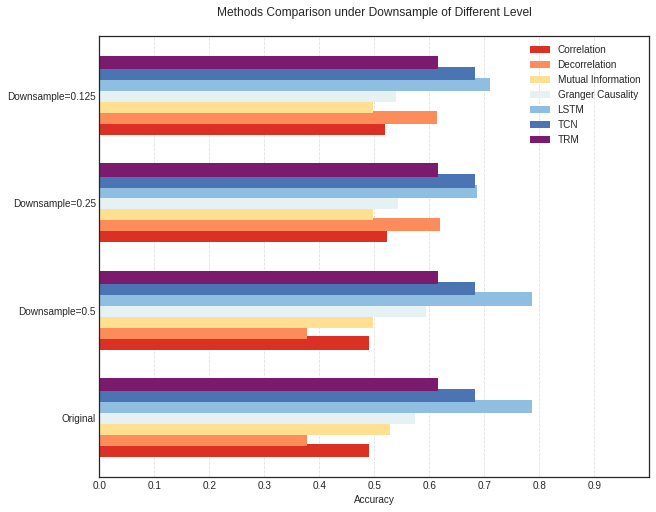

In [15]:
plot_condition_results(res, conditions=[f"Downsample={i}" for i in [0.5, 0.25, 0.125]], cohort_size=62)
plt.show()

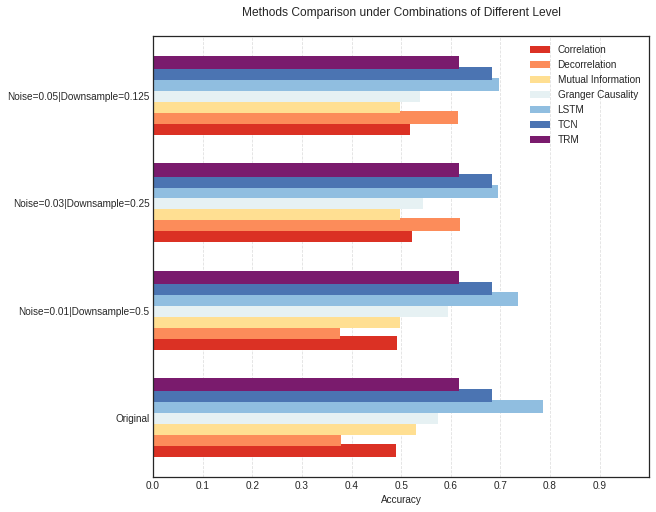

In [16]:
plot_condition_results(res, conditions=[f"Noise={i}|Downsample={j}" for i,j in [(0.01,0.5), (0.03,0.25), (0.05,0.125)]], cohort_size=62)
plt.show()

# Transfer Learning

In [21]:
# TODO: add transfer learning plot on three games
with open("./tests/regular_test_results.pkl", "rb") as f:
    transfer_res = pickle.load(f)
transfer_res

defaultdict(dict,
            {'DonkeyKong': {'corr_res': 0.49041151982529174,
              'decorr_res': 0.3784208012011192,
              'mutual_res': 0.5289701767556132,
              'granger_res': array([0.50774585, 0.54377943, 0.55463045, 0.54698697, 0.57448987])},
             'Pitfall': {'corr_res': 0.4694608633351245,
              'decorr_res': 0.39960594662367904,
              'mutual_res': 0.5284793121977431,
              'granger_res': array([0.52203117, 0.53653949, 0.52731506, 0.54692817, 0.60173742])},
             'SpaceInvaders': {'corr_res': 0.4828836998413058,
              'decorr_res': 0.37519836771707094,
              'mutual_res': 0.5255799894203884,
              'granger_res': array([0.5132623 , 0.52414418, 0.52278395, 0.53872894, 0.56993879])}})